In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [4]:
raw_df=pd.read_csv("weatherAUS.csv")
raw_df
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
raw_df.dropna(subset=['RainTomorrow'],inplace=True)

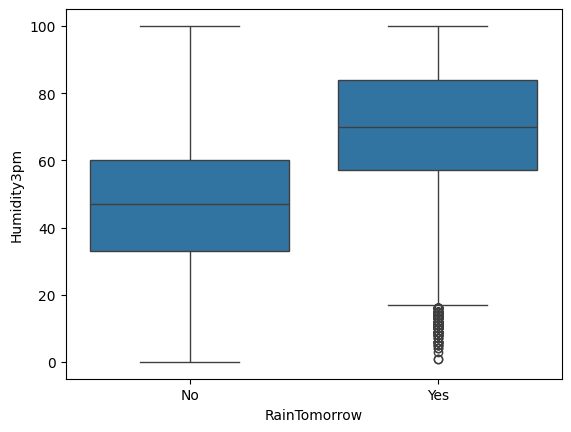

In [6]:
sns.boxplot(x='RainTomorrow', y='Humidity3pm', data=raw_df)
plt.show()

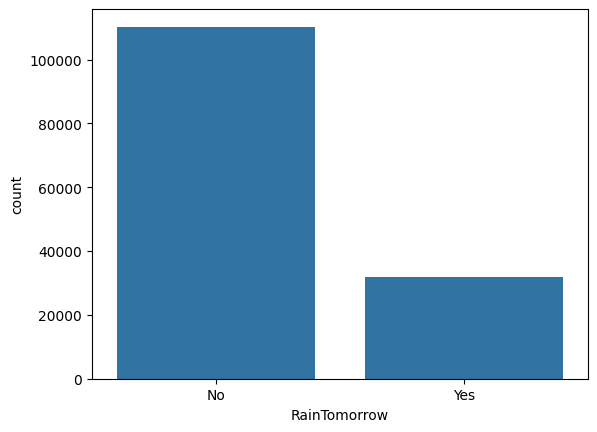

In [10]:
sns.countplot(x='RainTomorrow', data=raw_df)
plt.show()


# Preparing Data For Training 

Training, Validation and Test Sets

<Axes: title={'center': 'No of rows per year'}, xlabel='Date', ylabel='count'>

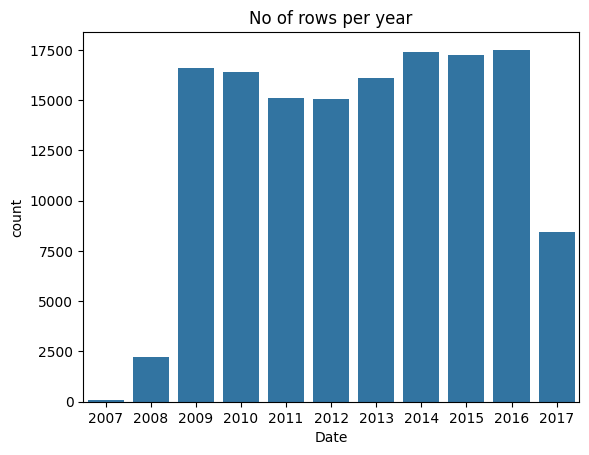

In [11]:
plt.title("No of rows per year")
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year)

Using data till 2014 for training set,2015 for validation and 2016 and 2017 for test 

In [13]:
year=pd.to_datetime(raw_df.Date).dt.year
train_df=raw_df[year<2015]
val_df=raw_df[year==2015]
test_df=raw_df[year>2015]
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


Input and target columns 

In [23]:
input_cols=list(train_df.columns)[1:-1]
target_col='RainTomorrow'
train_inputs=train_df[input_cols].copy()
train_target=train_df[target_col].copy()
val_inputs=val_df[input_cols].copy()
val_target=val_df[target_col].copy()
test_inputs=test_df[input_cols].copy()
test_target=test_df[target_col].copy()

In [25]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
print(numeric_cols)
print(categorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


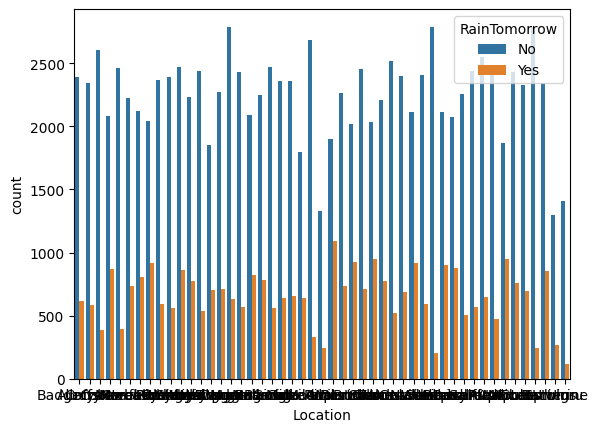

<Figure size 2000x1800 with 0 Axes>

In [30]:
sns.countplot(x='Location', hue='RainTomorrow', data=raw_df)
plt.figure(figsize=(20, 18))
plt.show()

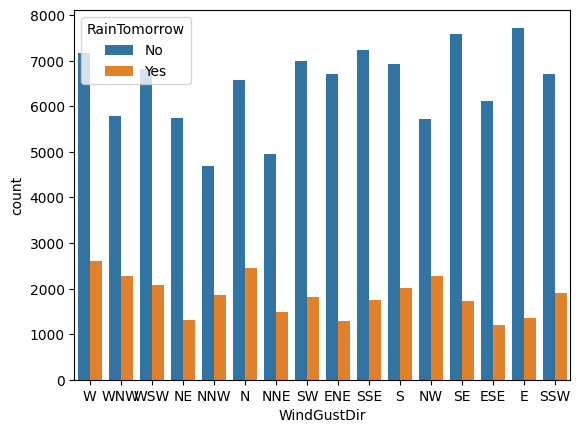

<Figure size 1400x800 with 0 Axes>

In [28]:
sns.countplot(x='WindGustDir', hue='RainTomorrow', data=raw_df)
plt.figure(figsize=(14, 8))
plt.show()

Imputing missing values 

In [33]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])
test_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])
val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


Encoding Categorical data 

In [45]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the training data's categorical columns
encoder.fit(raw_df[categorical_cols])

# Get the names of the encoded columns
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

# Transform the categorical columns in train, validation, and test sets
train_encoded = encoder.transform(train_inputs[categorical_cols])
val_encoded = encoder.transform(val_inputs[categorical_cols])
test_encoded = encoder.transform(test_inputs[categorical_cols])

# Convert the transformed data to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=train_inputs.index)
val_encoded_df = pd.DataFrame(val_encoded, columns=encoded_cols, index=val_inputs.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=test_inputs.index)

# Concatenate numeric columns and encoded categorical columns
X_train = pd.concat([train_inputs[numeric_cols], train_encoded_df], axis=1)
X_val = pd.concat([val_inputs[numeric_cols], val_encoded_df], axis=1)
X_test = pd.concat([test_inputs[numeric_cols], test_encoded_df], axis=1)

# Display the final feature sets
print("X_train:\n", X_train.head())
print("X_val:\n", X_val.head())
print("X_test:\n", X_test.head())

X_train:
     MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.516509  0.523629  0.001617     0.037723  0.525852       0.294574   
1  0.375000  0.565217  0.000000     0.037723  0.525852       0.294574   
2  0.504717  0.576560  0.000000     0.037723  0.525852       0.310078   
3  0.417453  0.620038  0.000000     0.037723  0.525852       0.139535   
4  0.613208  0.701323  0.002695     0.037723  0.525852       0.271318   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  WindDir3pm_SSE  \
0      0.153846      0.275862         0.71         0.22  ...             0.0   
1      0.030769      0.252874         0.44         0.25  ...             0.0   
2      0.146154      0.298851         0.38         0.30  ...             0.0   
3      0.084615      0.103448         0.45         0.16  ...             0.0   
4      0.053846      0.229885         0.82         0.33  ...             0.0   

   WindDir3pm_SSW  WindDir3pm_SW  WindDir3pm_W  WindDir3pm_WNW  \
0   

# Training and Visualizing Decision Trees


In [47]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier(random_state=42)
model.fit(X_train,train_target)

DecisionTreeClassifier(random_state=42)

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix
train_preds = model.predict(X_train)
pd.value_counts(train_preds)
train_probs = model.predict_proba(X_train)
accuracy_score(train_target, train_preds)


C:\Users\Amit\AppData\Local\Temp\ipykernel_3736\1208416111.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


0.9999797955307714

The training set accuracy is almost 100%

In [54]:
model.score(X_val, val_target)

0.7921188555510418

the accuracy on the validation set is just about 79%

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples

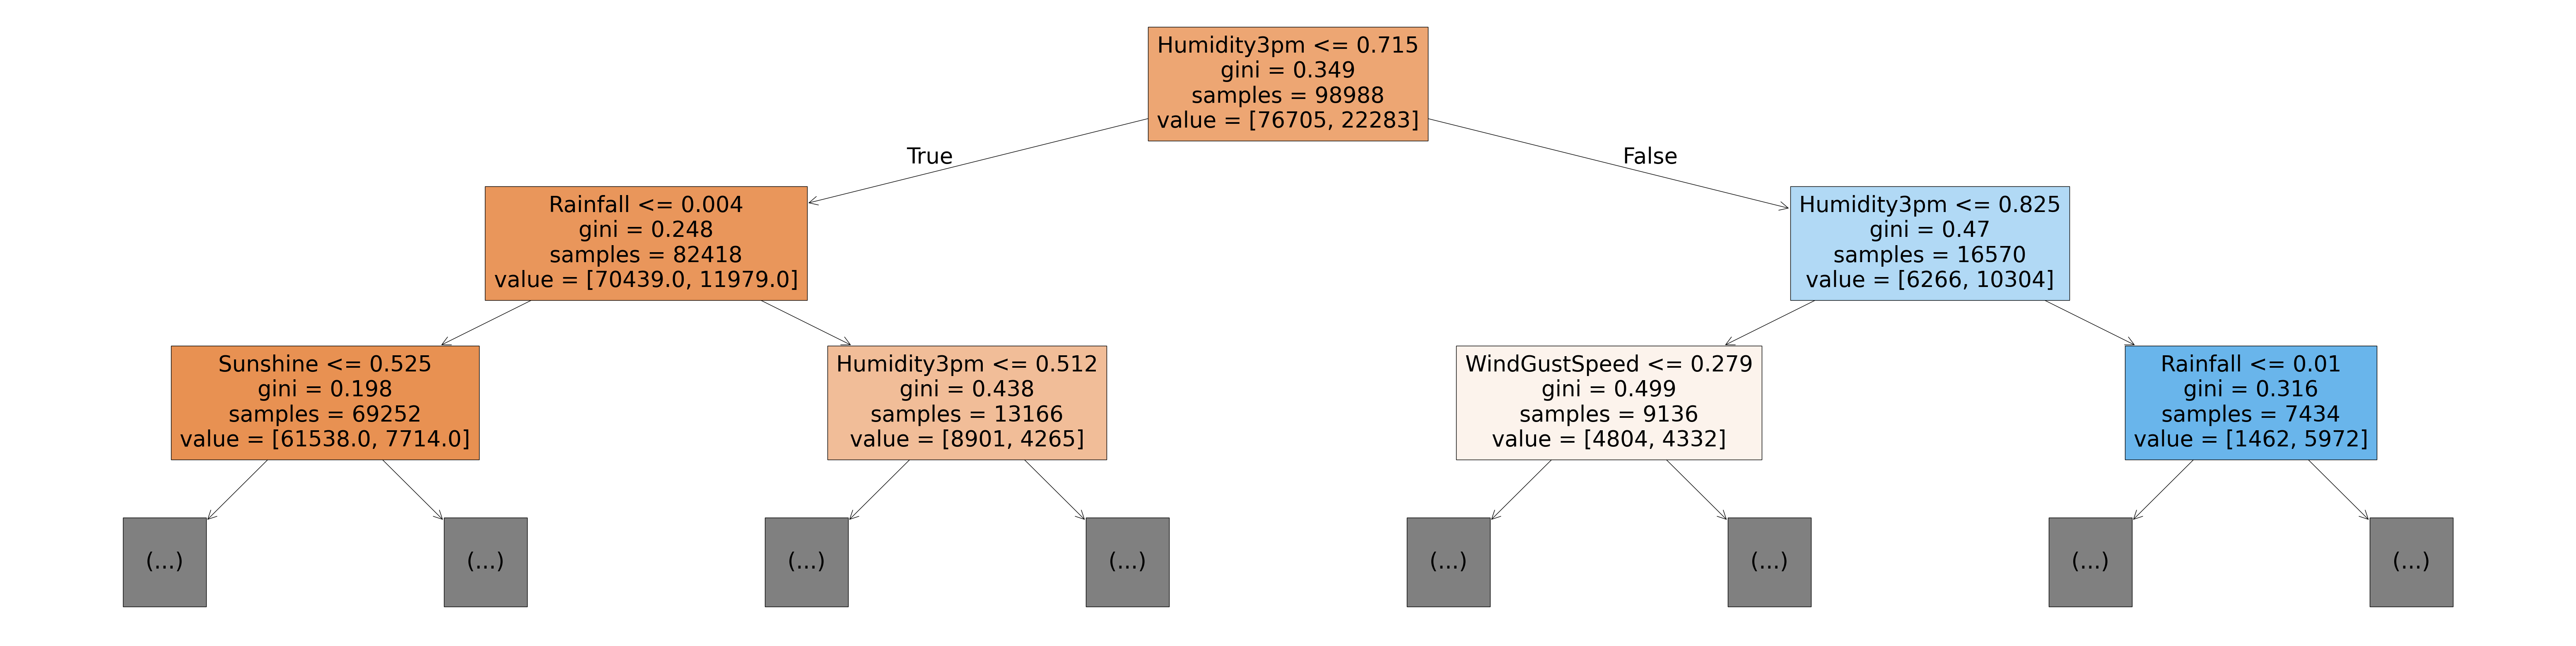

In [55]:
from sklearn.tree import plot_tree, export_text
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

# Hyperparameter Tuning and Overfitting

Max Depth 

In [ ]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)
model.fit(X_train, train_target)
print(model.score(X_train, train_target))
print(model.score(X_val, val_target))

0.8291308037337859
0.8334397307178921


the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly

# Training a Random Forest


In [66]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(random_state=42,n_jobs=-1)
model.fit(X_train,train_target)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [71]:
print(model.score(X_train,train_target))
print(model.score(X_val,val_target))

0.9999494888269285
0.8566537055307295


Once again, the training accuracy is 100%, but this time the validation accuracy is much better

# Hyperparameter training with Random Forest 

In [75]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30, 
                               class_weight={'No': 1, 'Yes': 1.5})

model.fit(X_train, train_target)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [76]:
model.score(X_train, train_target), model.score(X_val, val_target)

(0.9920192346547057, 0.8563054959085369)

In [72]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

In [80]:
test = {
    'MinTemp': 12.5, 
    'MaxTemp': 25.3, 
    'Rainfall': 0.0,  
    'Evaporation': 5.0, 
    'Sunshine': 8.0, 
    'WindGustSpeed': 30.0, 
    'WindSpeed9am': 10.0, 
    'WindSpeed3pm': 20.0, 
    'Humidity9am': 60.0, 
    'Humidity3pm': 45.0, 
    'Pressure9am': 1015.0, 
    'Pressure3pm': 1012.0, 
    'Cloud9am': 5.0, 
    'Cloud3pm': 3.0, 
    'Temp9am': 15.0, 
    'Temp3pm': 24.0, 
    'Location': 'Sydney', 
    'WindGustDir': 'N',  
    'WindDir9am': 'N', 
    'WindDir3pm': 'NW', 
    'RainToday': 'No'  
}
predict_input(test)

C:\Users\Amit\AppData\Local\Temp\ipykernel_3736\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
C:\Users\Amit\AppData\Local\Temp\ipykernel_3736\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
C:\Users\Amit\AppData\Local\Temp\ipykernel_3736\2435838903.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

('No', np.float64(0.8960645509161473))